# Homework 5

Use this notebook for Problems 1 and 2 on the homework.

Note: 
* For the parts that require modification, we have indicated where we would suggest you modify the code as follows:

    . . . [Provided code]

    ####START MODIFICATION 

    ####END MODIFICATION

    . . . [Provided code]
    

* While visualization can be useful for an intuitive understanding of the simulation, it can slow down the simulation significantly. If you find your code is taking too long to run, try setting the **visualize** flag in the md_175 cell to **False**.

## Preliminaries: Importing packages

Before beginning, let us import the packages that we will be working with:
* [numpy](http://www.numpy.org/): NumPy is the fundamental package for scientific computing with Python.
* [matplotlib.pyplot](https://matplotlib.org/): a Python 2D plotting library which produces publication quality figures.
* [mpl_toolkits](https://matplotlib.org/mpl_toolkits/index.html): additional matplotlib toolkits. Mainly used in this notebook for 3D visualization.
* [matplotlib.animation](https://matplotlib.org/api/animation_api.html): a matplotlib animation library
* setup_plot is a custom package written specifically for this program

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from utils import setup_plot

## Initialization

Unless the potential is of a simple form, we cannot sample starting positions exactly. A couple possible approaches:
* Start from some known configuration (e.g. from experiment)
* Randomly position particles, but we run into the risk of overlaps
* Initialize from lattice

For the purposes of this exercise, we will start from an ordered lattice. The function below returns an (num_dims x num_particles) numpy array which holds the initial xyz coordinates of the particles in our system.

In [2]:
def get_positions(num_part, nd, ncell, boxl):
    spacing = boxl/ncell
    positions_1D = np.linspace(spacing, boxl, ncell)
    if (nd == 3):
        r = np.meshgrid(positions_1D, positions_1D, positions_1D)
    elif (nd == 2):
        r = np.meshgrid(positions_1D, positions_1D)
    
    r = np.reshape(r, (nd, num_part))
    return r

## Interactions

For our simulation, we will employ periodic boundary conditions in conjunction with the minimum image convention

<img src="images/pbc.png" width="300px"/>

The below function, given an unwrapped position or distance vector, will return the vector when taking into consideration pbc and minimum image convention albeit in a "hacky" way. Effectively, the function is enforcing that

$$
pbc(r_{x}) = 
\begin{cases}
    r_x, & \text{if } r_x < boxl/2\\
    r_x - boxl, & \text{otherwise}
\end{cases}
$$

for each component x, y, z of the vector. Note that the function as implemented implicitly assumes that the simulation box is centered on the origin.

In [3]:
def pbc(vec, boxl):
    iboxl = 1.0 / boxl
    return vec - boxl * np.round(vec * iboxl)

For each iteration of the molecular dynamics simulation, we will need to calculate each pairwise interaction in our system. The function makes use of Newton's 3rd law to avoid redundant force calculations.

In [4]:
def interactions(r,num_part,boxl,nd):
    """Calculates the forces and potential for a system of num_part particles"""
    
    #Zero forces
    forces = np.zeros((nd, num_part))
    
    #Zero potential energy
    potential = 0
    
    #### (1a) START MODIFICATION 
    #empty list to hold distances
    dists = []
    ##### (1a) END MODIFICATION
    
    #loop over all pairs of particles in the simulation.
    for pA in range(num_part-1):
        for pB in range(pA+1, num_part):
            
            #coordinates for the first atom
            rA = r[:, pA]
        
            #coordinates for the second atom
            rB = r[:, pB]
        
            #find the distance between them and apply boundary conditions
            dr = pbc(rA - rB, boxl)
        
            #compute the magnitudes of the distances
            distance = np.linalg.norm(dr)
        
            ### (1a) START MODIFICATION
            ##Add new computed distances to array
            dists.append(distance)
            ## (1b) END MODIFICATION
            
            #compute forces and potential energies
            dv, df = LJ(distance)
        
            #add to the potential energy of the system
            potential = potential + dv
        
            #add forces using Newton's third law
            forces[:, pA] = forces[:, pA] + dr*df/distance
            forces[:, pB] = forces[:, pB] - dr*df/distance
                
    return potential, forces, dists

For this simulation, we will be employing the Lennard-Jones model to describe the particle interactions. Recall that the Lennard-Jones potential is a pairwise potential of the following form:

$$V(r) = 4\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6\right]$$



In [5]:
def LJ(dist):
    dr2 = dist*dist
    idr2 = 1/dr2
    idr6 = idr2*idr2*idr2
    dv = 4 * (idr6*idr6 - idr6)
    df = 48 * dist * idr2 * (idr6*idr6 - 0.5*idr6)
    return dv, df

Additionally, we also initialize the momenta for each particle in the system. Recall that from lecture, each of $p_x$, $p_y$, and $p_z$ can be drawn from a normal distributions such that

$$p_{avg} = 0, \sigma_p = \sqrt{mk_BT}$$


In [6]:
def get_momenta(nd, num_part, mass, temperature):
    """Sample momentum from the Maxwell-Boltzmann Distribution"""
    standard_dev = np.sqrt(temperature * mass) 
    mean = np.zeros(standard_dev.shape)
    return np.random.normal(mean, standard_dev, (nd, num_part))

## Main Simulation Loop

The following function integrates all of the above sections to run the MD simulation

In [27]:
def md_175(nsteps):
    #perform an initialization
    nd          = 2
    temperature = 300
#     dt          = 0.0005
    dt          = 0.0005
    gamma       = 200.0
    ncell       = 5
    density     = 0.25
#     ncell       = 10
#     density     = 0.6973
    visualize   = True
    
    #Print header
    print('Starting md_175: Molecular Dynamics Lennard Jones Code \n')
    print('------------------------------- \n')
    
    #check if inputs are acceptable
    if nd!=2 and nd!=3:
        raise ValueError('nd should either be 2 or 3. The value of nd was {}'.format(nd))
    
    #compute the box length from the density and the number of particles
    num_part = ncell**nd
    volume  = num_part/density
    boxl    = volume**(1/nd)
    
    #initialize 'mass', an array containing the mass of each individual particle
    mass    = np.ones(num_part)
    
    #initialize a name array for the particles so that all particles are of type 'A'
    names   = np.chararray(num_part)
    names[:] = "A"
    
    #print out all the parameters
    print('particles              = {} \n'.format(num_part))
    print('dimensions             = {} \n'.format(nd))
    print('volume of box          = {} \n'.format(volume))
    print('box side length        = {} \n'.format(boxl))
    print('mass of particles      = {} \n'.format(mass[0]))
    print('system temperature     = {} \n'.format(temperature))
    print('MD time step           = {} \n \n'.format(dt))
    
    print('Initializing Simulation System \n')
    
    #get the initial positions of the particles:start on a cubic grid
    r = get_positions(num_part, nd, ncell, boxl)
    r_track_noPBC = np.zeros((nd, num_part, nsteps+1))
    r_track_noPBC[:,:,0] = r
    
    #apply periodic boundary conditions so coordinates run -0.5boxl to 0.5boxl
    r = pbc(r, boxl)
    
    #calculate the initial momenta, energies, and forces on the particles
    p = get_momenta(nd, num_part, mass, temperature)
    
    ## (1b.ii+iii) START MODIFICATION
#     rdf_fig = plt.figure(figsize=(8,8))
    potential, forces, dists = interactions(r,num_part,boxl,nd)
    dists = np.array(dists)
    
#     bin_width = 0.05
#     bin_edges = np.arange(0,boxl,bin_width)
    
#     counts, bin_edges = np.histogram(dists,bin_edges)
#     bin_centers = (bin_edges[1:]+bin_edges[:-1])*0.5
#     rdf = 2 * counts/(num_part*2*np.pi*bin_width*bin_centers*density) #ok to double count distances
    
#     ax = rdf_fig.add_subplot(111, xlim=(0, boxl/2), ylim=(0, 5), xlabel='r', ylabel='g(r)')
#     ax.plot(bin_centers, rdf)
#     rdf_fig.canvas.draw()
    
    ## (1b.ii+iii) END MODIFICATION
    
    pe_0 = potential
    ke_0 = np.sum(np.square(p) / (2 * mass))
    E_0 = ke_0 + pe_0
    
    if visualize:
        #plot the initial positions
        fig, ax, particles = setup_plot(nd, boxl, 10)
        # update pieces of the animation
        if nd == 2:
            particles.set_data(r[0,:], r[1,:])
        elif nd == 3:
            particles.set_data(r[0,:], r[1,:])
            particles.set_3d_properties(r[2:])
        particles.set_markersize(10)
        fig.canvas.draw()
    
    print('Initialization complete: starting simulation \n')
    
#     #open files to output energies and temperature to
#     fid_e = open('energies.out','w')
#     fid_t = open('temperature.out','w')
    
    ##SIMULATION
    #Evolve the system for nsteps MD steps using velocity Verlet algorithm
    for step in range(nsteps):
        #evolve momenta by dt/2, before forces update
        p = p + 0.5*dt*forces;
        
        #find velocities so as to update the positions
        v = p/mass
        
        #evolve positions by dt and apply periodic boundary conditions
        dr = dt*v
        r_track_noPBC[:,:,step+1] = r_track_noPBC[:,:,step] + dr
        r = pbc(r+dr,boxl)
        
        ###(1b.iv) START MODIFICATION
        potential, forces, dists = interactions(r, num_part, boxl, nd)
        
#         #Reset counts after equilibration
#         if step == 99:
#             counts = counts*0
#         else:
#             #compute rdf and update it
#             counts_i, bin_edges = np.histogram(dists,bin_edges)
#             counts = counts + 2*counts_i
#             rdf = counts/(num_part*2*(step-99)*np.pi*bin_width*bin_centers*density)
        
#             #make the plot
#             rdf_fig.clf()
#             ax = rdf_fig.add_subplot(111, xlim=(0, boxl/2), ylim=(0, 5), xlabel='r', ylabel='g(r)')
#             ax.plot(bin_centers, rdf)
#             rdf_fig.canvas.draw()
        
        ## (1b.iv) END MODIFICATION
        
        #Evolve momenta by dt/2, after forces update
        p = p + 0.5*dt*forces
        
        #Thermostat the system: Anderson Thermostat
        if (np.random.uniform() < gamma*dt):
            p = get_momenta(nd, num_part, mass, temperature)
        
        #Calculate temperature and system energies
        kinetic_energy = np.sum(np.square(p) / (2 * mass))
        total_energy = kinetic_energy + potential
        T_obs = 2*kinetic_energy/(num_part*nd)
        
#         #Write out temperature and energies to files
#         fid_t.write("{} {} \n".format(step*dt,T_obs))
#         fid_e.write("{} {} {} {} \n".format(step*dt,total_energy-E_0,
#                                     potential-pe_0,kinetic_energy-ke_0))
        
        #update particles
        if visualize:
            fig.canvas.flush_events()
            if nd == 2:
                particles.set_data(r[0,:], r[1,:])
            elif nd == 3:
                particles.set_data(r[0,:], r[1,:])
                particles.set_3d_properties(r[2:])
            particles.set_markersize(10)
            fig.canvas.draw()
        
        if np.sum(np.isnan(r)) != 0:
            raise ValueError('Forces are too large. The temperature is likely too high')
            
    #close files
#     fid_t.close()
#     fid_e.close()
    print('Simulation complete \n')
#     return r_track_noPBC

Starting md_175: Molecular Dynamics Lennard Jones Code 

------------------------------- 

particles              = 25 

dimensions             = 2 

volume of box          = 100.0 

box side length        = 10.0 

mass of particles      = 1.0 

system temperature     = 300 

MD time step           = 0.0005 
 

Initializing Simulation System 



<IPython.core.display.Javascript object>


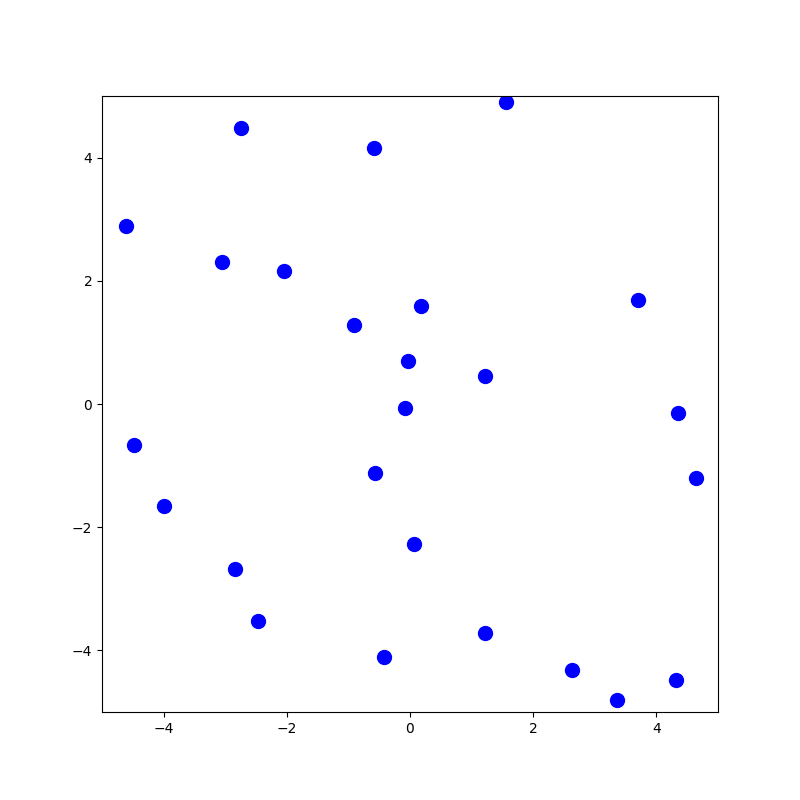

Initialization complete: starting simulation 

Simulation complete 



In [28]:
md_175(600)

## Problem 1

For this problem, you will modify the MD code so that as it propagates the particle trajectories, it simultaneously keeps a histogram consisting of the number of counts of each inter-particle distance. This can be used to generate a radial distribution function that updates over the course of the simulation. The code required to do this is not extensive, specifically because the distances are already computed when the pairwise interactions are calculated.

(a.) Modify the interactions function so that – in addition to its current purpose – it also serves to return an array of all computed distances.

(b.) We now want to modify the code in order to plot the radial distribution function (RDF) generated by our simulation.

i. First, we need to bin the distances i.e. count the number of times each distance has been observed. It is important that we set up our histogram with the appropriate bins. Given that we are using periodic boundary conditions, why should we only keep count of distances up to half the box length?

ii. Modify the appropriate section of md_175 to bin the distances of the system’s initial configuration using numpy's [histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html) function. If you do this correctly using the default parameters, your plot will look similar to the figure below:

<img src="images/plot_1.png" width="400px"/>

iii. What is the normalization factor that must be applied to the counts of distances in order to obtain the radial distribution function in 2 dimensions? Modify your code from part (ii) to plot the radial distribution function, using the normalization factor you deduced. For the initial configuration, the RDF plot should look similar to the figure below:

<img src="images/plt_2.png" width="400px"/>

iv. After each time step, we would like to update our RDF plot using the information from the new set of positions. To achieve this, modify the second empty code block in md_175. For the duration of the simulation, you should keep an unnormalized running count of distances. However, when we plot the RDF we need to average over time. Therefore, in addition to the normalization factor you deduced in part (iii), you also need to account for the growth of the counts with respect to the number of time steps that have elapsed.

v. When your code is working, you should be able to see a very sharp distribution in the initial steps that gradually broadens as the system evolves. The last modification you should make is to ignore the first 100 steps of the simulation in order to equilibrate the system, since you do not want to bias the final RDF toward the very regular initial conditions.

(c.) Once you are confident that you are generating RDFs properly, perform two production runs with the following parameters:

nd = 2;
temperature = X;
dt = 0.005;
gamma = 100;
ncell = 7;
density = 1.0;

Where temperature = X = 1.0 for run 1 and temperature = X = 20.0 for run 2. Leave all masses set
to 1 and all particle types as 'A'. For each temperature, run the simulation for a total of 500 steps (100
equilibration and 400 data collection). For each temperature, plot the radial distribution function you
obtain. What did you see as the RDFs were built up from individual time steps?

(d.) Based on the RDFs, in what phase were the particles for each run? How do you know?

(e.) Using your plotted RDF, give a rough estimate of the correlation distance for the higher
temperature run.


## Problem 2

The Lennard-Jones potential is a model for a real gas. For argon, reasonable parameters
are $\sigma$ = 0.34 nm and $\epsilon$ = 0.997 kJ/mol.

(a.) If you want to simulate 100 argon atoms in 2D at a temperature of 100K and a density of 1.178
g/cm3, what parameters would you input into the Lennard-Jones code for nd, temperature,
ncell, and density? For this simulation, use gamma = 200 and timestep = 0.0005.

(b.) Using your code from problem 1, perform the argon simulation described in (a) and calculate
the radial distribution function, 𝑔(𝑟). What phase are the atoms in?